# Sales pred simple ranking  
## ***Experience*** **52**:  
### -aggregated sales in different stores  
### -single-general learner  
### -without markdowns?  

## Contributions:
### - wide range of methods 
### - department based error(p_err and n_err) calculation
### - waited error ranking (check EXPLAIN method in exact folder)

In [1]:
# 0-importing necessary packages

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from pycaret.regression import *
import xgboost as xgb
import catboost as ctb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import shap
import sqlite3
print('Importing libraries: Done')

Importing libraries: Done


In [2]:
# 1-Inputs operation


# 1-1 Checking inputs
print("Folder's files : ",os.listdir('inputs'), '\n')

# 1-2 Reading input CSV files and assigning a name to each one of them 
dataset = pd.read_csv("inputs/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("inputs/features.csv",sep=',', header=0,names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("inputs/stores.csv", names=['Store','Type','Size'],sep=',', header=0)

# 1-3 Creating needed directories
os.makedirs('temp_test', exist_ok=True)
os.makedirs('input_analysis', exist_ok=True)
os.makedirs('pred_output', exist_ok=True)
os.makedirs('pred_output/exp52', exist_ok=True)
os.makedirs('output_analysis', exist_ok=True)
os.makedirs('output_analysis/exp52', exist_ok=True)

# 1-4 Flating data(merging different data bases into one table)
dataset = dataset.merge(stores, how='left').merge(features, how='left')  

# 1-5 Decreasing unnecessary memory usage 
dataset['Store'] = dataset['Store'].astype('int16')
dataset['Dept'] = dataset['Dept'].astype('int16')
dataset['weeklySales'] = dataset['weeklySales'].astype('float64')

# 1-6 Printing flatted dataset
print('─' * 100,'\n Original dataset sample: \n', dataset)

# 1-7 Creating sql database
database = "database.sqlite"
conn = sqlite3.connect(database)
dataset.to_sql(name='input', if_exists="replace", index = False, con=conn)
conn.close()

Folder's files :  ['features.csv', 'inputs.rar', 'inputs.zip', 'stores.csv', 'test.csv', 'train.csv'] 

──────────────────────────────────────────────────────────────────────────────────────────────────── 
 Original dataset sample: 
         Store  Dept        Date  weeklySales  isHoliday Type    Size  \
0           1     1  2010-02-05     24924.50      False    A  151315   
1           1     1  2010-02-12     46039.49       True    A  151315   
2           1     1  2010-02-19     41595.55      False    A  151315   
3           1     1  2010-02-26     19403.54      False    A  151315   
4           1     1  2010-03-05     21827.90      False    A  151315   
...       ...   ...         ...          ...        ...  ...     ...   
421565     45    98  2012-09-28       508.37      False    B  118221   
421566     45    98  2012-10-05       628.10      False    B  118221   
421567     45    98  2012-10-12      1061.02      False    B  118221   
421568     45    98  2012-10-19       760.01  

In [3]:
# 2-Data extraction

# 2-1 Deriving a sub-dataset from main dataset 
dataset_sub1 = dataset[['Date','Dept','Store', 'Type','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','isHoliday','weeklySales']]
dataset_sub1 = dataset_sub1.sort_index(axis=0)

# 2-2 getting list of unique departments' values
dept_list = dataset_sub1['Dept'].unique()
dept_list.sort()

# 2-3 getting list of unique stores' values
store_list = dataset_sub1['Store'].unique()
store_list.sort()

# 2-4 getting list of unique dates
date_list = dataset_sub1['Date'].unique()
date_list.sort()

# 2-5 Check printing 
print('Dataset_sub1: \n',dataset_sub1)
print('─' * 100,'\n List of Departments: \n',dept_list,'\n')
print('─' * 100,'\n List of Stores: \n',store_list,'\n')
print('─' * 100,'\n List of Dates: \n',date_list)

# Deriving a sub-dataset from main dataset which considers 9 more important features
#datasub_sub3 = dataset[['Date','Store','Dept','weeklySales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
#dataset_sub3 = dataset_sub3.sort_index(axis=0)
#Print('\n\n', dataset_sub3.tail(5))

Dataset_sub1: 
               Date  Dept  Store Type  MarkDown1  MarkDown2  MarkDown3  \
0       2010-02-05     1      1    A        NaN        NaN        NaN   
1       2010-02-12     1      1    A        NaN        NaN        NaN   
2       2010-02-19     1      1    A        NaN        NaN        NaN   
3       2010-02-26     1      1    A        NaN        NaN        NaN   
4       2010-03-05     1      1    A        NaN        NaN        NaN   
...            ...   ...    ...  ...        ...        ...        ...   
421565  2012-09-28    98     45    B    4556.61      20.64       1.50   
421566  2012-10-05    98     45    B    5046.74        NaN      18.82   
421567  2012-10-12    98     45    B    1956.28        NaN       7.89   
421568  2012-10-19    98     45    B    2004.02        NaN       3.18   
421569  2012-10-26    98     45    B    4018.91      58.08     100.00   

        MarkDown4  MarkDown5  isHoliday  weeklySales  
0             NaN        NaN      False     24924.50

In [4]:
# 3-Data cleaning

# 3-1 this function identifies departmets in different stores that have incomplete data or have below 0 sales values. the function then makes a dictionary of outliers(Test:OK)
def outlier_identifier(df, border_value, store_list, dept_list):
    data_map = pd.DataFrame(columns=['store', 'dept', 'number_of_entries', 'target_false_count', 'outlier_flag'])
    for i in store_list:
        for j in dept_list:
            number_of_entries = df[(df.Store == i) & (df.Dept == j)].Date.count()
            number_of_entries = number_of_entries.astype('int16')
            target_false_count = df[(df.weeklySales <= border_value) & (df.Store == 
                                                                        i) & (df.Dept == j)].weeklySales.count()
            target_false_count = target_false_count.astype('int16')
            if (number_of_entries == 143) & (target_false_count == 0):
                outlier_flag = 0
            else:
                outlier_flag = 1
            new_row = {'store': i, 'dept': j, 'number_of_entries': number_of_entries, 'target_false_count': target_false_count, 'outlier_flag': outlier_flag}
            data_map.loc[len(data_map)] = new_row
    return data_map

# 3-2 this function removes departmets in different stores that have incomplete data or have below 0 sales values.(Test:OK)
def outlier_remover(df, removal_map):
    for i in removal_map.index:
        a = removal_map.iloc[[i]].store
        a.reset_index(drop=True, inplace=True)
        b = removal_map.iloc[[i]].dept
        b.reset_index(drop=True, inplace=True)
        print('Store:', a[0], 'Department:', b[0],' Removed as outlier!','\n')
        index = df[(df.Store == a[0]) & (df.Dept == b[0])].index
        for j in index:
            df.drop(j , inplace=True)
    return df

# 3-3 Executing outlier identifier and save it as a mapping dataframe to know which store and department mix should be droped(Test:OK)
data_map = outlier_identifier(dataset_sub1, 0, store_list, dept_list)
removal_map = data_map[['store','dept','outlier_flag']]
removal_map = removal_map[removal_map.outlier_flag == 1]
removal_map.reset_index(drop=True, inplace=True)

# 3-4 Printing percentage of outlier data in compare with whole data
print('outlier percentage:', data_map[data_map.outlier_flag == 1].store.count() / 3645 ,'─' * 100, '\n')

# 3-5 Executing outlier remover
dataset_sub2 = outlier_remover(dataset_sub1, removal_map)

# 3-6 Filling empty numeric values with 0  &  reseting index
dataset_sub2 = dataset_sub2.fillna(0)
dataset_sub2 = dataset_sub2.reset_index(drop=True)

# 3-7 Outlier removing process is considerably time consuming, therefore we save it and recall cleaned data later.
dataset_sub2.to_csv('temp_test/dataset_sub2_exp52.csv') 

# 3-8 Saving cleaned dataset in sql db with given name 'clean_input'.
conn = sqlite3.connect(database)
dataset_sub2.to_sql(name='clean_input', if_exists="replace", index = False, con=conn)
conn.close()

# 3-9 Printing the result of data cleaning process
print('─' * 100, '\n Cleaned Dataset: \n', dataset_sub2)    

outlier percentage: 0.2792866941015089 ──────────────────────────────────────────────────────────────────────────────────────────────────── 

Store: 1 Department: 6  Removed as outlier! 

Store: 1 Department: 18  Removed as outlier! 

Store: 1 Department: 39  Removed as outlier! 

Store: 1 Department: 43  Removed as outlier! 

Store: 1 Department: 45  Removed as outlier! 

Store: 1 Department: 47  Removed as outlier! 

Store: 1 Department: 48  Removed as outlier! 

Store: 1 Department: 50  Removed as outlier! 

Store: 1 Department: 51  Removed as outlier! 

Store: 1 Department: 54  Removed as outlier! 

Store: 1 Department: 65  Removed as outlier! 

Store: 1 Department: 77  Removed as outlier! 

Store: 1 Department: 78  Removed as outlier! 

Store: 1 Department: 96  Removed as outlier! 

Store: 1 Department: 99  Removed as outlier! 

Store: 2 Department: 18  Removed as outlier! 

Store: 2 Department: 39  Removed as outlier! 

Store: 2 Department: 43  Removed as outlier! 

Store: 2 Depa

In [5]:
# 4-Reading cleaned dataset and updating some lists after cleaning

# 4-1 Reading saved clean data from memory
#dataset_sub2 = pd.read_csv("temp_test/dataset_sub2_exp51.csv", names=['Date','Dept','Store', 'Type','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','isHoliday','weeklySales'],sep=',', header=0)
conn = sqlite3.connect(database)
dataset_sub2 = pd.read_sql_query("SELECT * from clean_input", conn)
conn.close()

dataset_sub3 = dataset_sub2[['Date','Dept','weeklySales']]

# 4-2 Updating list of unique departments' values
dept_list = dataset_sub2['Dept'].unique()
dept_list.sort()

# 4-3 Updating list of unique stores' values
store_list = dataset_sub2['Store'].unique()
store_list.sort()

# 4-4 Updating list of unique dates
date_list = dataset_sub2['Date'].unique()
date_list.sort()

print('List of Departments:',dept_list,'\n')
print('─' * 100, '\n List of Stores: \n',store_list,'\n')
print('─' * 100, '\n List of Dates: \n',date_list)


List of Departments: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 46 48 49 50 52 55 56 58
 59 60 65 67 71 72 74 79 80 81 82 83 85 87 90 91 92 93 94 95 96 97 98] 

──────────────────────────────────────────────────────────────────────────────────────────────────── 
 List of Stores: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] 

──────────────────────────────────────────────────────────────────────────────────────────────────── 
 List of Dates: 
 ['2010-02-05' '2010-02-12' '2010-02-19' '2010-02-26' '2010-03-05'
 '2010-03-12' '2010-03-19' '2010-03-26' '2010-04-02' '2010-04-09'
 '2010-04-16' '2010-04-23' '2010-04-30' '2010-05-07' '2010-05-14'
 '2010-05-21' '2010-05-28' '2010-06-04' '2010-06-11' '2010-06-18'
 '2010-06-25' '2010-07-02' '2010-07-09' '2010-07-16' '2010-07-23'
 '2010-07-30' '2010-08-06' '2010-08-13' '2010-08-

In [17]:
# 5-Defining experiment process, models, and methods

# 5-1 This function executes each step of the whole experiment process one by one.(Test:NA)
#Experiment51:
def experiment52(df, split_date, mdls, mix_mdls):
    y = aggregator(df)
    z = create_features(y)
    train, test = split_data(z, split_date)
    train2 = train.drop(columns=['Date'])
    test2 = test.drop(columns=['Date'])
    print('>create features and split_data func is Done! \n')
    
    best1, best2, best3, best4, best5 = mlsetup(train2, test2)
    print('\n >mlsetup func is Done! \n')

    result_log = result_log_init(test)
    result_log = create_models(mdls, test2, result_log)
    result_log = mix_methods(test2, result_log, best1, best2, best3, best4, best5)
    result_log.to_csv('output_analysis/exp52/result_log.csv')

    output_anal = output_analyzer(result_log, mdls, mix_mdls)
    output_anal.to_csv('output_analysis/exp52/output_anal.csv')
    
    print('\n >create_models func is Done! \n')
        
    #result_log_aggr_exp1.to_csv('output_analysis/exp1/result_log_aggr_exp1.csv')
    process_end_msg = '>>>>>>>>>>> Experience 52 is DONE! <<<<<<<<<<<<'
    print(process_end_msg)
    pass

# 5-2 This function aggregates stores weekly sales(Test:OK)
def aggregator(df):
    aggr = df.groupby(['Date','Dept'], as_index=False).sum()
    return aggr

# 5-3 This function gets a ataframe input and gives a dataframe output with transformed features. (Test:OK) 
# also the function reduces data types to minimum ram needed
def create_features(df):
    features = df
    features['Date'] = pd.to_datetime(df['Date'])
    features['dayofweek'] = df['Date'].dt.dayofweek
    features['quarter'] = df['Date'].dt.quarter
    features['month'] = df['Date'].dt.month
    features['year'] = df['Date'].dt.year
    features['dayofyear'] = df['Date'].dt.dayofyear
    features['dayofmonth'] = df['Date'].dt.day
    features['weekofyear'] = df['Date'].dt.weekofyear

    cols_int16 = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear', 'Dept']
    for col in cols_int16:
        features['{}'.format(col)] = df['{}'.format(col)].astype('int16')

    cols_float32 = ['weeklySales']
    for col in cols_float32:
        features['{}'.format(col)] = df['{}'.format(col)].astype('float32')
        
    X = features[['Date','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear', 'Dept', 'weeklySales']]
    X.index = features.index
    print('\n >>features: \n',X)
    return X

# 5-4 This function derives train and test datasets from a tmie-series database due to an input date(Test:OK)
def split_data(df, split_date):
    return df[df.Date < split_date].copy(), \
            df[df.Date >= split_date].copy()

# 5-5 This function sets up machine-learning process configurations(Test:NA)
def mlsetup(train, test):
    reg = setup(data = train,
            test_data = test,
            target = 'weeklySales',
            categorical_features = ['Dept','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear'],
            #numeric_features = ['Date', 'Dept','Store','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],
            #preprocess = False,
            imputation_type = None, #We dont want to impute missing values because they are alreay imputed.
            #numeric_imputation = 'mean',
            #polynomial_features = False, #it means we do not want to take existing features and raise them to a power to capture non-linear relationships between the feature and the target variable.
            #transformation = False,
            #normalize = False,
            #normalize_method = 'zscore',
            #transform_target = False,
            #remove_multicollinearity = False,
            #multicollinearity_threshold = 0.95,
            remove_outliers = False,
            #outliers_method = 'ee' #options are 'ee', 'lof', 'iforest',
            #outliers_threshhold = 0.05,
            #feature_selection = False,
            #feature_selection_method = 'sequential',
            #feature_selection_estimator = 'lightgbm',
            #n_features_to_select = 0.2,
            use_gpu = True,
            #profile = True,
            #fold_strategy = 'kfold', #other options are 'kfold', 'groupkfold', 'timeseries'
            fold = 2,  
            #fold_groups = 'dept',
            #data_split_shuffle = False,
            #fold_shuffle = True,
           )
    print('\n \n >>ML setup  IS  DONE! \n \n')
    best1 = compare_models(sort = 'MAPE', n_select = 1)
    best2 = compare_models(sort = 'MAPE', n_select = 2)
    best3 = compare_models(sort = 'MAPE', n_select = 3)
    best4 = compare_models(sort = 'MAPE', n_select = 4)
    best5 = compare_models(sort = 'MAPE', n_select = 5)
    #print('\n \n >>best = compare_models IS  DONE! \n \n')
    #evaluate_model(best)
    #print('\n \n >>evaluate_model(best) IS  DONE! \n \n')
    return best1, best2, best3, best4, best5
    #pass


# 5-6 This function
def result_log_init(test_df):  
    #initiating result log 
    result_log = pd.DataFrame()
    result_log.index = test_df.index
    result_log['Date'] = test_df['Date']
    result_log['Dept'] = test_df['Dept']
    result_log['actual'] = test_df['weeklySales'] 
    return result_log
    
# 5-7 This function creates, tunes, plots, finalizes, predicts, and evaluates all models in mdls list for a set of data (Test:NA)
def create_models(mdls, test, result_log):
    for mdl in mdls:
        mdll = create_model('{}'.format(mdl))
        print('\n \n >>mdll = create_model(mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        tuned_mdl = tune_model(mdll, n_iter = 2)
        print('\n \n >>tuned_mdl = tune_model(mdll) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        #final_model_name = f'final_{mdl}'
        final_model = finalize_model(tuned_mdl)
        print('\n \n >>final_mdl = finalize_model(tuned_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        plt(tuned_mdl)
        
        print(final_model)
        print('\n \n >>print(final_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        #save_model(final_model, f'{mdl}')
        pred = predict_model(final_model, data=test)
        pred.to_csv('pred_output/exp52/{}_pred.csv'.format(mdl))
        print('\n \n >>pred_mdl = predict_model(final_mdl, data=test) for Model:{} IS  DONE! \n \n'.format(mdl))

        result_log = result_logger(mdl, pred, result_log)
        print('\n \n >> Prediction with Model:{}  IS  DONE!'.format(mdl))
        
    return result_log   
    #pass

# 5-8 This function
def plt(mdl):
    plot_model(mdl)
    plot_model(mdl, plot = 'error')
    plot_model(mdl, plot='feature')
    plot_model(mdl, plot = 'learning')
    plot_model(mdl, plot = 'manifold')
    plot_model(mdl, plot = 'feature_all')
    plot_model(mdl, plot = 'parameter')
    #plot_model(final_blend, plot = 'error')

    #interpret_model(mdl)
    #interpret_model(mdl, plot = 'correlation')
    #interpret_model(mdl, plot = 'reason', observation = 12)
        
    #plot_model(mdll)
    #print('\n \n >>plot_model(mdll) for Model:{} IS  DONE! \n \n'.format(mdl))
    #plot_model(mdll, plot = 'error')
    #print('\n \n >>plot_model(mdll, plot = error) for Model:{} IS  DONE! \n \n'.format(mdl))
    #plot_model(tuned_mdl, plot = 'feature')
    print('\n \n >>plotting is  DONE! \n \n')
    pass

# 5-9 This function
def result_logger(mdl, pred, result_log):  
    result_log[mdl] = pred.prediction_label
    result_log['{}_ape'.format(mdl)] = ((result_log.actual - result_log[mdl]) / result_log.actual).abs() 
    result_log['{}_pe'.format(mdl)] = ((result_log.actual - result_log[mdl]) / result_log.actual) 
    result_log['{}_pos_pe'.format(mdl)] = result_log[(result_log['{}_pe'.format(mdl)] >= 0)]['{}_pe'.format(mdl)]
    result_log['{}_neg_pe'.format(mdl)] = result_log[(result_log['{}_pe'.format(mdl)] < 0)]['{}_pe'.format(mdl)]
    result_log['{}_err_p2'.format(mdl)] = ((result_log.actual - result_log[mdl]) ** 2)
    return result_log

# 5-10 This function
def mix_methods(test, result_log, best1, best2, best3, best4, best5):
    
    #dt = create_model('dt')
    #tuned_dt = tune_model(dt, n_iter = 2)
    
    #rf = create_model('rf')
    #tuned_rf = tune_model(rf, n_iter = 2)

#Blend2

    blend2 = blend_models(best2)
    tuned_blend2 = tune_model(blend2, n_iter = 2)
    pred = predict_model(tuned_blend2, data=test)
    result_log = result_logger('blend2', pred, result_log)
    plt_mix(tuned_blend2)
    pred.to_csv('pred_output/exp52/blend2_pred.csv')
    print(f'\n \n >> Prediction with Model:blend{i+2}  IS  DONE!')

#Blend3
    blend3 = blend_models(best3)
    tuned_blend3 = tune_model(blend3, n_iter = 2)
    pred = predict_model(tuned_blend3, data=test)
    result_log = result_logger('blend3', pred, result_log)
    plt_mix(tuned_blend3)
    pred.to_csv('pred_output/exp52/blend3_pred.csv')
    print('\n \n >> Prediction with Model:blend3  IS  DONE!')

#Blend4
    blend4 = blend_models(best4)
    tuned_blend4 = tune_model(blend4, n_iter = 2)
    pred = predict_model(tuned_blend4, data=test)
    result_log = result_logger('blend4', pred, result_log)
    plt_mix(tuned_blend4)
    pred.to_csv('pred_output/exp52/blend4_pred.csv')
    print('\n \n >> Prediction with Model:blend4  IS  DONE!')

#Blend4
    blend5 = blend_models(best5)
    tuned_blend5 = tune_model(blend5, n_iter = 2)
    pred = predict_model(tuned_blend5, data=test)
    result_log = result_logger('blend5', pred, result_log)
    plt_mix(tuned_blend5)
    pred.to_csv('pred_output/exp52/blend5_pred.csv')
    print('\n \n >> Prediction with Model:blend5  IS  DONE!')

#stacker2
    stacker2 = stack_models(best2)
    tuned_stacker2 = tune_model(stacker2, n_iter = 2)
    pred = predict_model(tuned_stacker2, data = test)
    result_log = result_logger('stacker2', pred, result_log)
    plt_mix(tuned_stacker2)
    pred.to_csv('pred_output/exp52/stacker2_pred.csv')
    print('\n \n >> Prediction with Model:stacker2  IS  DONE!')   

#stacker3
    stacker3 = stack_models(best3)
    tuned_stacker3 = tune_model(stacker3, n_iter = 2)
    pred = predict_model(tuned_stacker3, data = test)
    result_log = result_logger('stacker3', pred, result_log)
    plt_mix(tuned_stacker3)
    pred.to_csv('pred_output/exp52/stacker3_pred.csv')
    print('\n \n >> Prediction with Model:stacker3  IS  DONE!')   

#stacker4
    stacker4 = stack_models(best4)
    tuned_stacker4 = tune_model(stacker4, n_iter = 2)
    pred = predict_model(tuned_stacker4, data = test)
    result_log = result_logger('stacker4', pred, result_log)
    plt_mix(tuned_stacker4)
    pred.to_csv('pred_output/exp52/stacker4_pred.csv')
    print('\n \n >> Prediction with Model:stacker4  IS  DONE!')   

#stacker5
    stacker5 = stack_models(best5)
    tuned_stacker5 = tune_model(stacker5, n_iter = 2)
    pred = predict_model(tuned_stacker5, data = test)
    result_log = result_logger('stacker5', pred, result_log)
    plt_mix(tuned_stacker5)
    pred.to_csv('pred_output/exp52/stacker5_pred.csv')
    print('\n \n >> Prediction with Model:stacker5  IS  DONE!')   
    
    #bagging
    bagged_best = ensemble_model(best1, n_estimators=2)
    #tuned_bagged_rf = tune_model(bagged_rf, n_iter = 2)
    pred = predict_model(bagged_best, data = test)
    result_log = result_logger('bagged_best', pred, result_log)
    plt_mix(bagged_best)
    pred.to_csv('pred_output/exp52/bagged_best.csv')
    print('\n \n >> Prediction with Model:bagged_best  IS  DONE!')   
    
    #boosting
    boosted_best = ensemble_model(best1, method = 'Boosting')
    #tuned_boosted_rf = tune_model(boosted_rf, n_iter = 2)
    pred = predict_model(boosted_best, data = test)
    result_log = result_logger('boosted_best', pred, result_log)
    plt_mix(boosted_best)
    pred.to_csv('pred_output/exp52/boosted_best.csv')
    print('\n \n >> Prediction with Model:boosted_best  IS  DONE!')   
    return result_log

# 5-11 This function
def plt_mix(mdl):
    plot_model(mdl)
    plot_model(mdl, plot = 'error')
    #plot_model(mdl, plot='feature')
    plot_model(mdl, plot = 'learning')
    plot_model(mdl, plot = 'manifold')
    #plot_model(mdl, plot = 'feature_all')
    plot_model(mdl, plot = 'parameter')
    #plot_model(final_blend, plot = 'error')

    #interpret_model(mdl)
    #interpret_model(mdl, plot = 'correlation')
    #interpret_model(mdl, plot = 'reason', observation = 12)
        
    #plot_model(mdll)
    #print('\n \n >>plot_model(mdll) for Model:{} IS  DONE! \n \n'.format(mdl))
    #plot_model(mdll, plot = 'error')
    #print('\n \n >>plot_model(mdll, plot = error) for Model:{} IS  DONE! \n \n'.format(mdl))
    #plot_model(tuned_mdl, plot = 'feature')
    print('\n \n >>plotting is  DONE! \n \n')
    pass

# 5-12 This function
def output_analyzer(result_log, mdls, mix_mdls):
    output_anal = pd.DataFrame()
    mdls_and_mix = mdls + mix_mdls
    output_anal.index = mdls_and_mix

    for mdl in mdls_and_mix:
        pos_pe_mean = result_log['{}_pos_pe'.format(mdl)].mean()
        max_pos_pe = result_log['{}_pos_pe'.format(mdl)].max()
        neg_pe_mean = result_log['{}_neg_pe'.format(mdl)].mean()
        max_neg_pe = result_log['{}_neg_pe'.format(mdl)].min()
        mape = result_log['{}_ape'.format(mdl)].mean()
        err_sum = result_log['{}_err_p2'.format(mdl)].sum()
        err_count = result_log['{}_err_p2'.format(mdl)].count()
        var = (err_sum / (err_count - 1))
        sd = ((err_sum / (err_count - 1))**0.5)

        output_anal.at[mdl, 'pos_pe_mean'] = pos_pe_mean
        output_anal.at[mdl, 'max_pos_pe'] = max_pos_pe
        output_anal.at[mdl, 'neg_pe_mean'] = neg_pe_mean
        output_anal.at[mdl, 'max_neg_pe'] = max_neg_pe
        output_anal.at[mdl, 'mape'] = mape
        output_anal.at[mdl, 'var'] = var
        output_anal.at[mdl, 'sd'] = sd
    return output_anal
    


 >>features: 
             Date  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0     2010-02-05          4        1      2  2010         36           5   
1     2010-02-05          4        1      2  2010         36           5   
2     2010-02-05          4        1      2  2010         36           5   
3     2010-02-05          4        1      2  2010         36           5   
4     2010-02-05          4        1      2  2010         36           5   
...          ...        ...      ...    ...   ...        ...         ...   
10148 2012-10-26          4        4     10  2012        300          26   
10149 2012-10-26          4        4     10  2012        300          26   
10150 2012-10-26          4        4     10  2012        300          26   
10151 2012-10-26          4        4     10  2012        300          26   
10152 2012-10-26          4        4     10  2012        300          26   

       weekofyear  Dept   weeklySales  
0               5     1  8.8183

,Description,Value
0,Session id,4050
1,Target,weeklySales
2,Target type,Regression
3,Original data shape,"(10153, 9)"
4,Transformed data shape,"(10153, 23)"
5,Transformed train set shape,"(6319, 23)"
6,Transformed test set shape,"(3834, 23)"
7,Ordinal features,1
8,Categorical features,8
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P3000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,62236.9524,30352812390.0373,173817.5448,0.9467,0.2228,0.1578,1.9950
dt,Decision Tree Regressor,72956.0617,62892018646.5220,250598.0140,0.8898,0.2529,0.1695,0.1500
xgboost,Extreme Gradient Boosting,57137.6035,31762749440.0000,177109.4141,0.9441,0.3211,0.2501,0.9850
et,Extra Trees Regressor,95544.4939,54754945346.6982,223493.1724,0.9033,0.3616,0.3240,0.5350
lightgbm,Light Gradient Boosting Machine,78383.0782,37351558307.6230,193032.0996,0.9344,0.5648,0.7954,1.2600
gbr,Gradient Boosting Regressor,160748.8922,66123914261.8452,256660.6448,0.8839,0.9629,2.8702,0.3500
catboost,CatBoost Regressor,293881.7120,209006099312.8576,453609.6005,0.6323,1.0848,4.2811,12.9700
knn,K Neighbors Regressor,400087.6719,350349754368.0000,591902.3125,0.3855,1.2384,5.0180,0.2800
huber,Huber Regressor,500442.0886,613270631273.7570,783114.1620,-0.0756,1.4898,7.5075,0.2050
par,Passive Aggressive Regressor,513890.1390,613137547138.8909,782960.6711,-0.0757,1.5422,7.9315,0.1200


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,62236.9524,30352812390.0373,173817.5448,0.9467,0.2228,0.1578,0.4800
dt,Decision Tree Regressor,72956.0617,62892018646.5220,250598.0140,0.8898,0.2529,0.1695,0.1200
xgboost,Extreme Gradient Boosting,57137.6035,31762749440.0000,177109.4141,0.9441,0.3211,0.2501,0.9400
et,Extra Trees Regressor,95544.4939,54754945346.6982,223493.1724,0.9033,0.3616,0.3240,0.4100
lightgbm,Light Gradient Boosting Machine,79112.9511,37714381715.8977,193904.1390,0.9338,0.5417,0.6810,1.2350
gbr,Gradient Boosting Regressor,160748.8922,66123914261.8452,256660.6448,0.8839,0.9629,2.8702,0.3150
catboost,CatBoost Regressor,293881.7120,209006099312.8576,453609.6005,0.6323,1.0848,4.2811,12.1350
knn,K Neighbors Regressor,400087.6719,350349754368.0000,591902.3125,0.3855,1.2384,5.0180,0.2950
huber,Huber Regressor,500442.0886,613270631273.7570,783114.1620,-0.0756,1.4898,7.5075,0.2100
par,Passive Aggressive Regressor,513890.1390,613137547138.8909,782960.6711,-0.0757,1.5422,7.9315,0.1050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,62236.9524,30352812390.0373,173817.5448,0.9467,0.2228,0.1578,0.4800
dt,Decision Tree Regressor,72956.0617,62892018646.5220,250598.0140,0.8898,0.2529,0.1695,0.1150
xgboost,Extreme Gradient Boosting,57137.6035,31762749440.0000,177109.4141,0.9441,0.3211,0.2501,0.9000
et,Extra Trees Regressor,95544.4939,54754945346.6982,223493.1724,0.9033,0.3616,0.3240,0.4150
lightgbm,Light Gradient Boosting Machine,79651.9929,37674042334.3432,193810.9743,0.9338,0.5418,0.6907,1.2350
gbr,Gradient Boosting Regressor,160748.8922,66123914261.8452,256660.6448,0.8839,0.9629,2.8702,0.3150
catboost,CatBoost Regressor,293881.7120,209006099312.8576,453609.6005,0.6323,1.0848,4.2811,12.2350
knn,K Neighbors Regressor,400087.6719,350349754368.0000,591902.3125,0.3855,1.2384,5.0180,0.2750
huber,Huber Regressor,500442.0886,613270631273.7570,783114.1620,-0.0756,1.4898,7.5075,0.2050
par,Passive Aggressive Regressor,513890.1390,613137547138.8909,782960.6711,-0.0757,1.5422,7.9315,0.1250


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,62236.9524,30352812390.0373,173817.5448,0.9467,0.2228,0.1578,0.4900
dt,Decision Tree Regressor,72956.0617,62892018646.5220,250598.0140,0.8898,0.2529,0.1695,0.1150
xgboost,Extreme Gradient Boosting,57137.6035,31762749440.0000,177109.4141,0.9441,0.3211,0.2501,0.9550
et,Extra Trees Regressor,95544.4939,54754945346.6982,223493.1724,0.9033,0.3616,0.3240,0.4150
lightgbm,Light Gradient Boosting Machine,82590.2113,38057985384.3873,194721.1886,0.9332,0.5732,0.7949,1.2400
gbr,Gradient Boosting Regressor,160748.8922,66123914261.8452,256660.6448,0.8839,0.9629,2.8702,0.3200
catboost,CatBoost Regressor,293881.7120,209006099312.8576,453609.6005,0.6323,1.0848,4.2811,12.0350
knn,K Neighbors Regressor,400087.6719,350349754368.0000,591902.3125,0.3855,1.2384,5.0180,0.2850
huber,Huber Regressor,500442.0886,613270631273.7570,783114.1620,-0.0756,1.4898,7.5075,0.1900
par,Passive Aggressive Regressor,513890.1390,613137547138.8909,782960.6711,-0.0757,1.5422,7.9315,0.1250


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,62236.9524,30352812390.0373,173817.5448,0.9467,0.2228,0.1578,0.4850
dt,Decision Tree Regressor,72956.0617,62892018646.5220,250598.0140,0.8898,0.2529,0.1695,0.1150
xgboost,Extreme Gradient Boosting,57137.6035,31762749440.0000,177109.4141,0.9441,0.3211,0.2501,0.9000
et,Extra Trees Regressor,95544.4939,54754945346.6982,223493.1724,0.9033,0.3616,0.3240,0.4250
lightgbm,Light Gradient Boosting Machine,78611.7060,37278591115.0693,192819.0761,0.9345,0.5355,0.6837,1.2400
gbr,Gradient Boosting Regressor,160748.8922,66123914261.8452,256660.6448,0.8839,0.9629,2.8702,0.3350
catboost,CatBoost Regressor,293881.7120,209006099312.8576,453609.6005,0.6323,1.0848,4.2811,12.3750
knn,K Neighbors Regressor,400087.6719,350349754368.0000,591902.3125,0.3855,1.2384,5.0180,0.2750
huber,Huber Regressor,500442.0886,613270631273.7570,783114.1620,-0.0756,1.4898,7.5075,0.1850
par,Passive Aggressive Regressor,513890.1390,613137547138.8909,782960.6711,-0.0757,1.5422,7.9315,0.1100



 >mlsetup func is Done! 



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,53632.7188,38802763776.0000,196984.1719,0.9311,0.2973,0.1736
1,60642.4883,24722735104.0000,157234.6562,0.9572,0.3449,0.3266
Mean,57137.6035,31762749440.0000,177109.4141,0.9441,0.3211,0.2501
Std,3504.8848,7040014336.0000,19874.7578,0.0130,0.0238,0.0765



 
 >>mdll = create_model(mdl) for Model:xgboost IS  DONE! 
 



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,72360.0469,37221441536.0000,192928.5938,0.9339,0.5826,0.7507
1,79218.4219,30901483520.0000,175788.1719,0.9465,0.6149,1.0427
Mean,75789.2344,34061462528.0000,184358.3828,0.9402,0.5988,0.8967
Std,3429.1875,3159979008.0000,8570.2109,0.0063,0.0162,0.1460


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:xgboost IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:xgboost IS  DONE! 
 



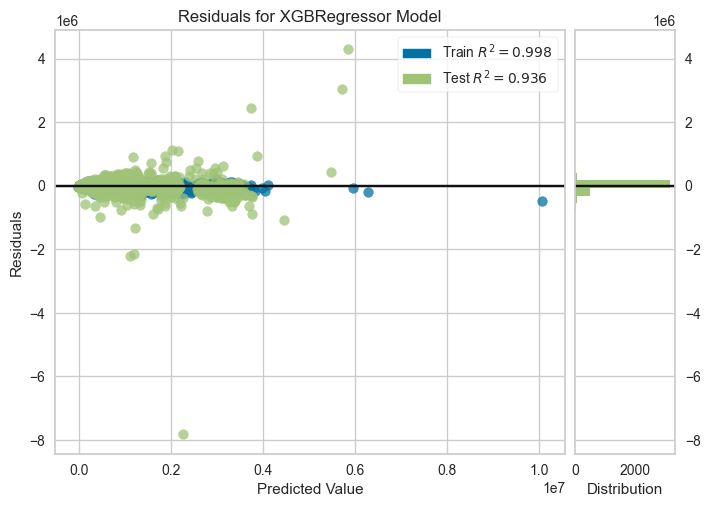

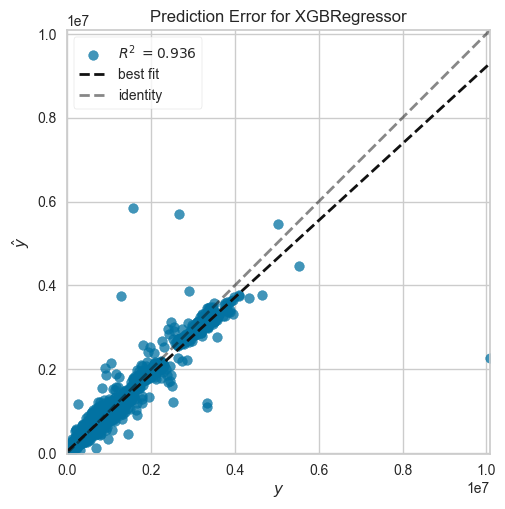

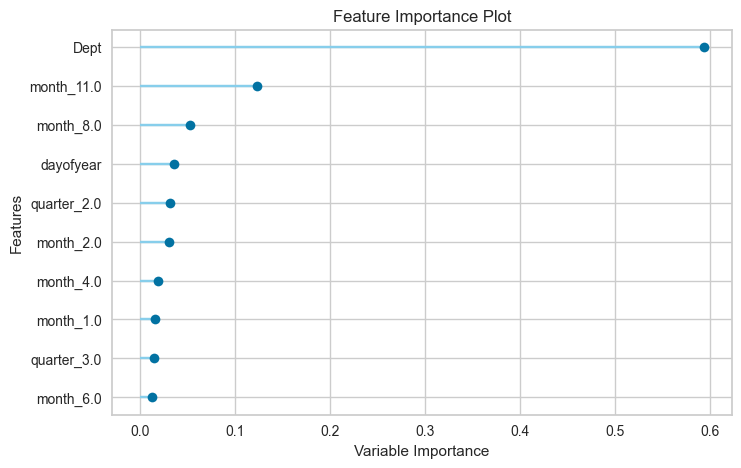

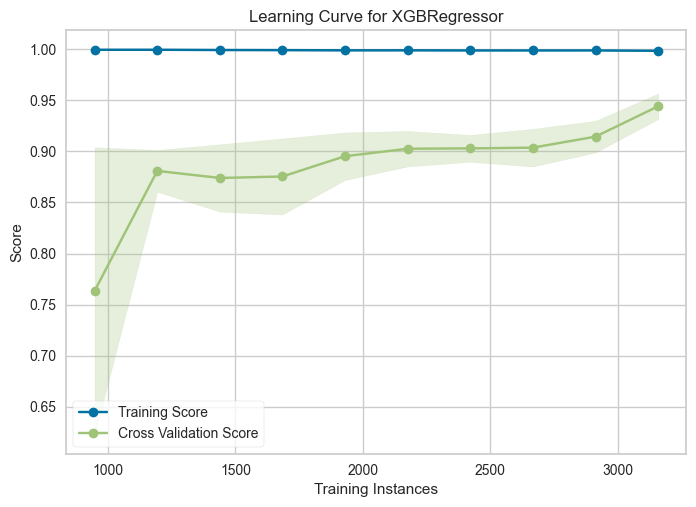

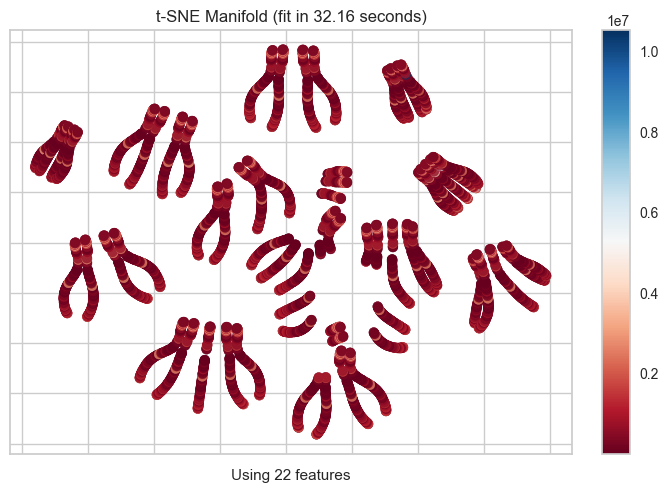

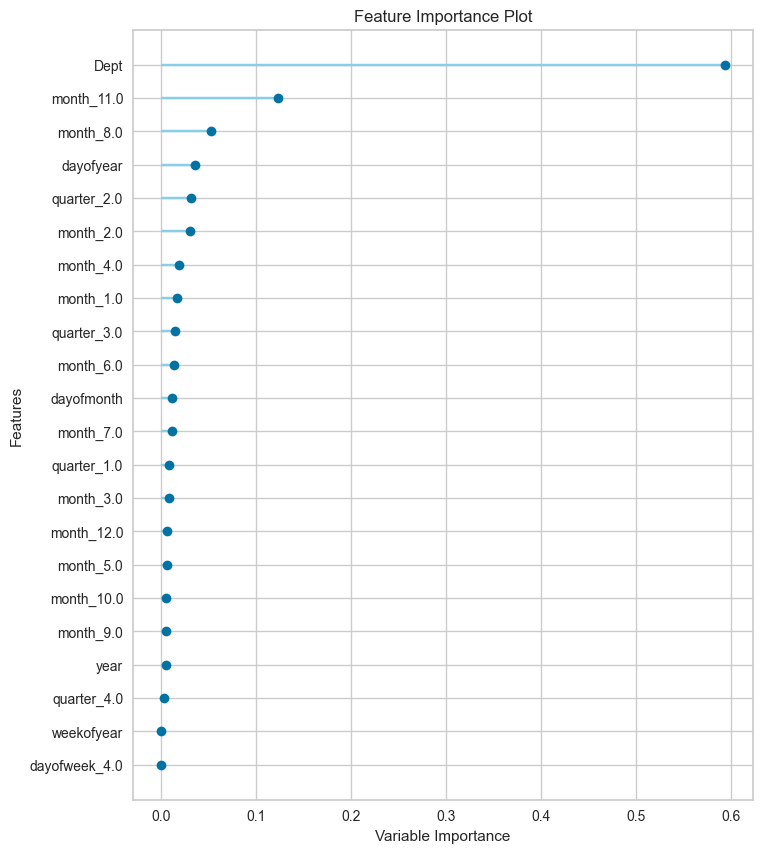

,Parameters
objective,reg:squarederror
base_score,None
booster,gbtree
callbacks,None
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,None
device,gpu
early_stopping_rounds,None
enable_categorical,False



 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('ordinal_encoding',
                 TransformerWrapper(include=['year'],
                                    transformer=OrdinalEncoder(cols=['year'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'year',
                                                                         'data_type': dtype('float64'),
                                                                         'mapping': 2010.0    0
2011.0    1
NaN      -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['dayofweek', 'quarter', 'month'],
                                    tran...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constra

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,26697.7285,1914996480.0000,43760.6719,0.9969,0.2870,0.1841



 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:xgboost IS  DONE! 
 


 
 >> Prediction with Model:xgboost  IS  DONE!


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,67109.1640,34470102202.2740,185661.2566,0.9388,0.2216,0.1649
1,57364.7408,26235522577.8006,161973.8330,0.9546,0.2240,0.1506
Mean,62236.9524,30352812390.0373,173817.5448,0.9467,0.2228,0.1578
Std,4872.2116,4117289812.2367,11843.7118,0.0079,0.0012,0.0072



 
 >>mdll = create_model(mdl) for Model:rf IS  DONE! 
 



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,416430.6671,487022081276.5716,697869.6736,0.1353,1.2813,4.7202
1,434598.6052,529831523844.6811,727895.2698,0.0822,1.3591,5.9835
Mean,425514.6362,508426802560.6263,712882.4717,0.1088,1.3202,5.3518
Std,9083.9691,21404721284.0548,15012.7981,0.0265,0.0389,0.6317


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:rf IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:rf IS  DONE! 
 



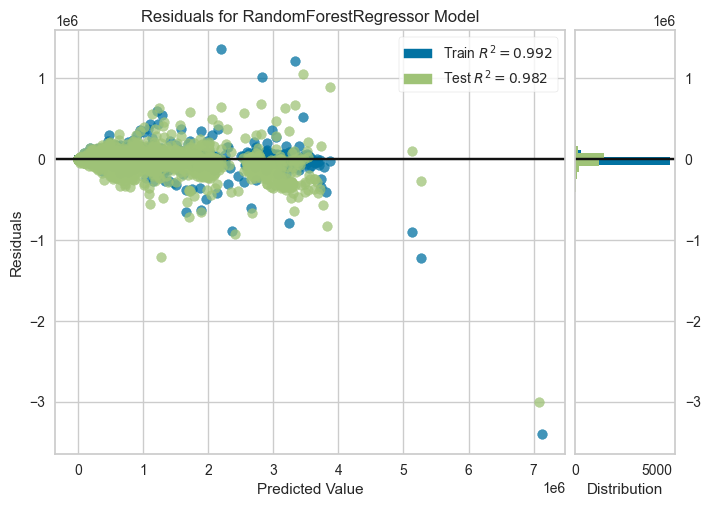

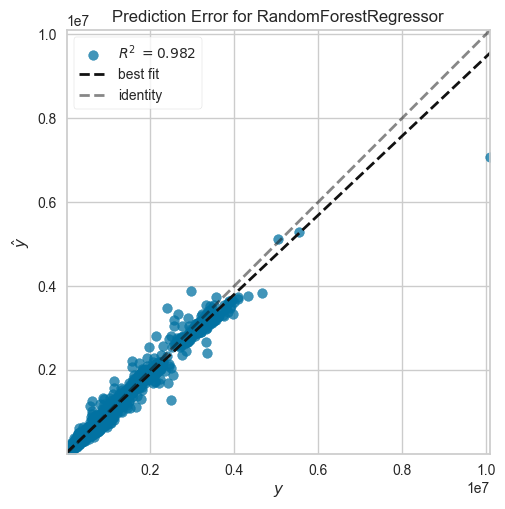

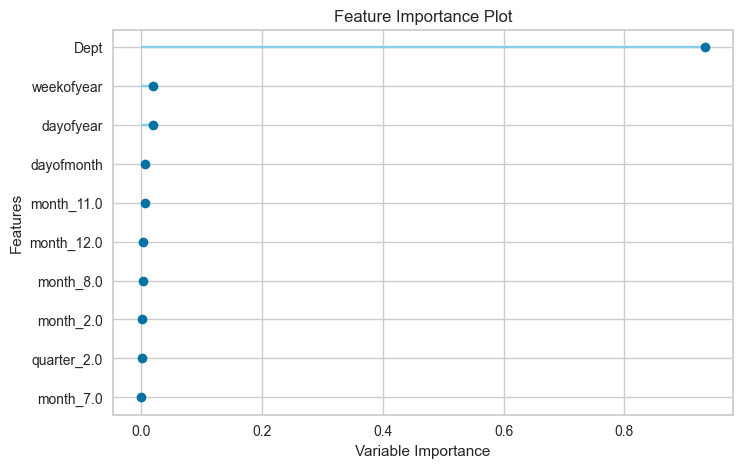

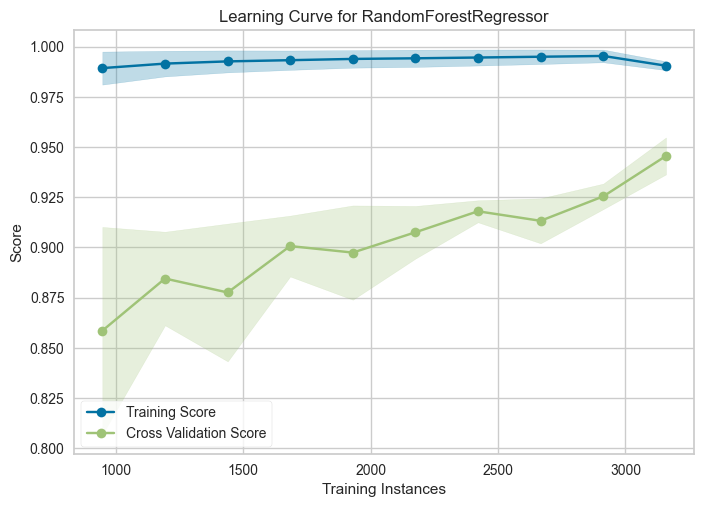

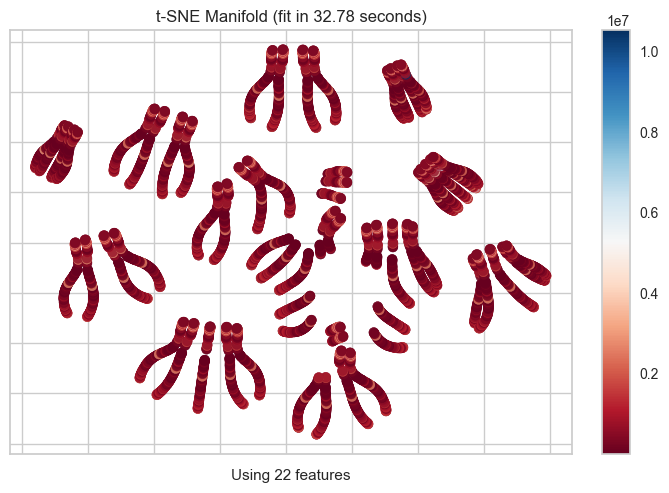

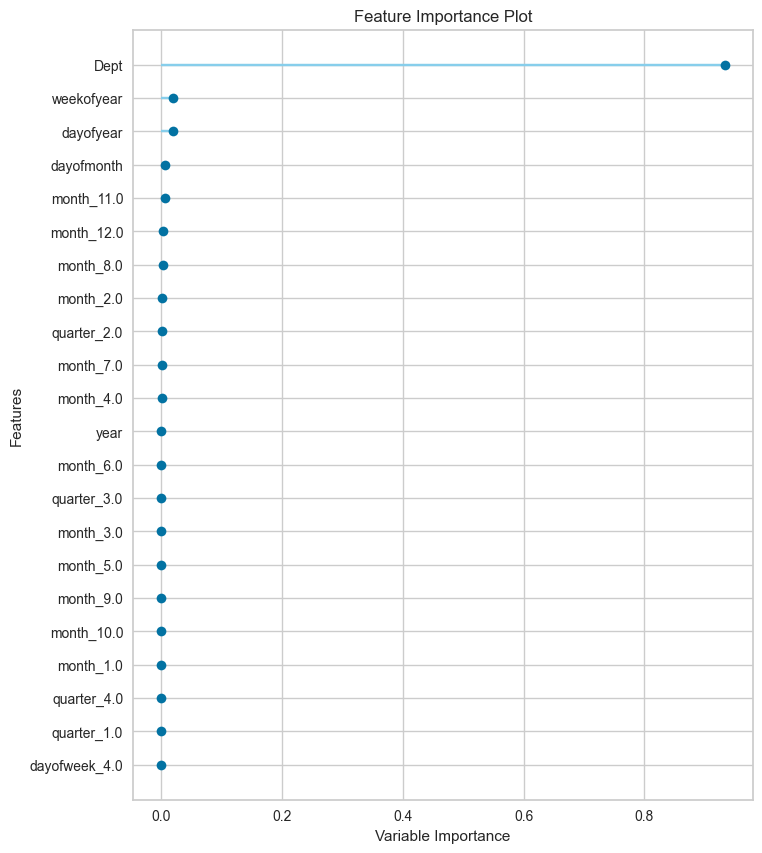

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2



 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('ordinal_encoding',
                 TransformerWrapper(include=['year'],
                                    transformer=OrdinalEncoder(cols=['year'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'year',
                                                                         'data_type': dtype('float64'),
                                                                         'mapping': 2010.0    0
2011.0    1
NaN      -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['dayofweek', 'quarter', 'month'],
                                    transformer=OneHotEncoder(cols=['dayofweek',
                                                                    'quarter',
                                                                 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12372.1887,1067491137.7905,32672.4829,0.9983,0.0472,0.0251



 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:rf IS  DONE! 
 


 
 >> Prediction with Model:rf  IS  DONE!


ValueError: Estimator b does not have the required fit() method.

In [15]:
# 6-Setting parameters and executing the experiment
#mdls = ['xgboost', 'catboost', 'tr', 'lightgbm', 'gbr', 'huber', 'ada', 'par', 'omp', 'en', 'lasso', 'llar', 'br', 'ridge', 'lar', 'lr','dt', 'rf', 'et']
# excluded: 'dummy', 'knn', 'ransac', 'tr', 'kr', 'svm'
mdls = ['xgboost', 'rf']

#['blend', 'bag', 'boost', 'stack']
mix_mdls = ['blend2', 'blend3', 'blend4', 'blend5', 'stacker2', 'stacker3', 'stacker4', 'stacker5', 'bagged_best', 'boosted_best']

experiment52(dataset_sub3, '2011-10-19', mdls, mix_mdls)

0
1
2
3
4
